# Visualization Code for OddLot

This Jupyter Notebook will hold all of the code for creating the visualizations used in Charon SSG's slide deck, as well as explanations for what the visualizations mean. There will also be code for the calculation of statistically important financial metrics, such as the Sharpe ratio.

***Visualizations:***
1. Time plot with lines for total tender offers and odd lot tender offers
2. Charts visualizing expected annualized return for each year and expected absolute return over time 
3. Charts visualizing best case and worst case returns (annualized and absolute returns)
4. Charts visualizing expected annualized return correlated with quantitative variables
5. Distribution of type of tender offer
6. A chart that demonstrates if there is an association between expected annualized return and tender type

***Calculations:***
1. Calculate Sharpe ratio and Sortino ratio
2. Calculate outliers

## Base Code
This base code will be needed for all of the visualizations. So I'm putting it right at the start. This includes things such as importing needed modules and reading in and cleaning the data.

Estimated return is simply shares buying back/outstanding shares, discretized by the increments


In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime


odd_lot_data = pd.read_csv('./data/raw-data/url_data_1.csv')
print("Raw data: ")
print(odd_lot_data)
# Remove any data rows where there have been errors or duplicates
odd_lot_data.dropna(subset=['exp date'], inplace=True)
odd_lot_data.drop_duplicates(subset=['cik', 'date'], inplace = True)

# Make the date columns into actual python datetimes
odd_lot_data['date'] = pd.to_datetime(odd_lot_data['date'])
odd_lot_data['exp date'] = pd.to_datetime(odd_lot_data['exp date'])
odd_lot_data['px date'] = pd.to_datetime(odd_lot_data['px date'])
odd_lot_data['pay date'] = pd.to_datetime(odd_lot_data['exp date']).apply(lambda date: date +  datetime.timedelta(days=6))
# odd_lot_data['year'] = pd.DatetimeIndex(odd_lot_data['date']).year

odd_lot_data.sort_values('date', inplace=True)

print("\n\n\nModified data:")
print(odd_lot_data)

# Initialize fonts
georgia_font = {'fontname':'Georgia'}

Raw data: 
         cik        date                                                url  \
0     946738   5/28/2003  https://www.sec.gov//Archives/edgar/data/94673...   
1       1750   4/27/2015  https://www.sec.gov//Archives/edgar/data/1750/...   
2    1551152    5/1/2018  https://www.sec.gov//Archives/edgar/data/15511...   
3     846676   5/22/2018  https://www.sec.gov//Archives/edgar/data/84667...   
4     846676   4/30/2010  https://www.sec.gov//Archives/edgar/data/84667...   
5     846676   5/22/2018  https://www.sec.gov//Archives/edgar/data/84667...   
6     846676   4/30/2010  https://www.sec.gov//Archives/edgar/data/84667...   
7     864415   2/14/2012  https://www.sec.gov//Archives/edgar/data/86441...   
8     899629  12/20/2001  https://www.sec.gov//Archives/edgar/data/89962...   
9    1295721   5/13/2008  https://www.sec.gov//Archives/edgar/data/12957...   
10   1295721   12/6/2007  https://www.sec.gov//Archives/edgar/data/12957...   
11   1342068   8/24/2015  https://www.sec

## The Naive Strategy
Buy 99 stocks of every tender lot offer, simple.

In [108]:
odd_lot_data['naive'] = 'y'
print(odd_lot_data['naive'])

131    y
176    y
72     y
67     y
157    y
31     y
8      y
156    y
107    y
172    y
30     y
64     y
0      y
169    y
155    y
26     y
44     y
149    y
60     y
160    y
158    y
159    y
24     y
47     y
168    y
28     y
25     y
165    y
92     y
17     y
      ..
99     y
14     y
98     y
174    y
35     y
166    y
61     y
38     y
63     y
136    y
21     y
91     y
163    y
96     y
161    y
1      y
39     y
23     y
27     y
100    y
20     y
84     y
13     y
22     y
108    y
2      y
145    y
106    y
34     y
16     y
Name: naive, Length: 75, dtype: object


## The Conservative Strategy
Only buy if the low price is above the initial buy price, ergo you can't ever lose money.

In [135]:
def conservative_strategy(row):
    if row['trading px'] <= row['low']:
        return 'y'
    elif row['trading px'] <= row['tender px']:
        return 'y'
    else:
        return 'n'
odd_lot_data['conservative'] = odd_lot_data.apply(lambda row: conservative_strategy(row), axis=1)
print(odd_lot_data['conservative'].value_counts())

y    40
n    35
Name: conservative, dtype: int64


## The Simulator
This code will simulate our return based on what instructions we give it.

In [153]:
def simulate(principal, outlook, strategy):
    portfolio = [principal]
    # Action days are any day where the portfolio could change value (i.e. on filing days and pay days)
    dates = odd_lot_data['date'] + odd_lot_data['pay date']
    # Iterrate through every filing and pay day for the odd lot offers
    for date in dates:
        # Check whether the strategy wants up to buy or not
        if row[strategy] == 'y':
            # Set sell price to whatever outlook we are expecting, if the value is nan, use the tender px
            sell_price = row[outlook]
            if np.isnan(sell_price) or sell_price is None:
                sell_price = row['tender px']
            # add the new portfolio value after buying and selling 99 shares
            portfolio.append(portfolio[-1] + (sell_price - row['trading px']) * 99)
        else:
            portfolio.append(portfolio[-1])
            portfolio.append(portfolio[-1])
    return portfolio

## Worst Case
Using outlook equals 'low', what is our return for the two strategies

In [154]:
# Calculate worst case for the naive strategy
low_naive_portfolio = simulate(10000, 'low', 'naive')
low_naive_return = (low_naive_portfolio[-1] / low_naive_portfolio[0]) - 1
print(low_naive_portfolio)
print(low_naive_return)

# Calculate worst case for the conservative strategy
low_conservative_portfolio = simulate(10000, 'low', 'conservative')
low_conservative_return = (low_conservative_portfolio[-1] / low_conservative_portfolio[0]) - 1
print(low_conservative_portfolio)
print(low_conservative_return)

AttributeError: 'Series' object has no attribute 'date'

## Best Case
Using outlook equals 'high', what is our return for the two strategies

In [138]:
# Calculate best case for the naive strategy
high_naive_portfolio = simulate(10000, 'high', 'naive')
high_naive_return = (high_naive_portfolio[-1] / high_naive_portfolio[0]) - 1
print(high_naive_portfolio)
print(high_naive_return)

# Calculate best case for the conservative strategy
high_conservative_portfolio = simulate(10000, 'high', 'conservative')
high_conservative_return = (high_conservative_portfolio[-1] / high_conservative_portfolio[0]) - 1
print(high_conservative_portfolio)
print(high_conservative_return)

[10000, 10160.875, 10507.375, 10594.0, 10615.78, 10665.28, 10910.334700000001, 10934.094700000001, 11030.124700000002, 11188.524700000002, 11990.424700000001, 12485.424700000001, 12646.794700000002, 12755.694700000002, 12928.944700000002, 13013.094700000001, 13211.094700000001, 13214.0647, 13369.494700000001, 15678.174700000001, 15720.744700000001, 15798.9547, 15959.3347, 16032.5947, 15980.1247, 15892.0147, 16297.9147, 16967.1547, 17414.6347, 17623.524699999998, 17872.0147, 17991.8047, 18012.5947, 18178.9147, 19193.6647, 19316.4247, 19585.7047, 19721.3347, 20096.5447, 20226.234699999997, 20662.824699999997, 20578.674699999996, 20862.804699999997, 20986.554699999997, 21405.324699999997, 21900.324699999997, 22047.834699999996, 22102.284699999997, 22189.404699999996, 22302.264699999996, 22531.944699999996, 22582.434699999998, 23060.604699999996, 23287.314699999995, 23553.624699999997, 23567.484699999997, 23835.774699999998, 23939.7247, 24201.0847, 24206.0347, 24392.1547, 24576.2947, 24658

## Expected Annualized Return by Year
This graph shows the expects annualized return by year if someone were to have invested the full amount possible in all odd lot tender offers. ***Explain assumptions made to calculate estimated return for any odd lot***

In [58]:
# Add a column for the year of each tender offer (based on filing data)
print(odd_lot_data)
low_annualized_average_return = odd_lot_data.groupby('year')['low return'].mean()
high_annualized_average_return = odd_lot_data.groupby('year')['high return'].mean()
print(low_annualized_average_return)
print(high_annualized_average_return)

# # Calculate annualize worst case return for each stock
# worst_return = odd_lot_data['low'] - odd_lot_data['trading px']
# worst_normalized_return = worst_return / odd_lot_data['trading px']

# # Calculate annualized best case return for each stock
# best_return = odd_lot_data['high'] - odd_lot_data['trading px']
# best_normalized_return = best_return / odd_lot_data['trading px']

# print(worst_normalized_return)
# print(worst_normalized_return.mean())
# print(best_normalized_return)
# print(best_normalized_return.mean())

# Plot it
# labels = ('Worst Case', 'Best Case')
# x_pos = np.arange(len(labels))
# returns = [worst_normalized_return.mean(), best_normalized_return.mean()]
 
# plt.bar(x_pos, returns, align='center', alpha=0.5)

# plt.yticks(**georgia_font)
# plt.xticks(x_pos, labels, **georgia_font)
# plt.ylabel('Return', **georgia_font)
# plt.title('Odd Lot Average Return', **georgia_font)

# ax = plt.subplot(111)
# ax.bar(x-0.2, y,width=0.2,color='b',align='center')
# ax.bar(x, z,width=0.2,color='g',align='center')
# ax.bar(x+0.2, k,width=0.2,color='r',align='center')
 
# plt.show()

         cik       date                                                url  \
0     946738 2003-05-28  https://www.sec.gov//Archives/edgar/data/94673...   
1       1750 2015-04-27  https://www.sec.gov//Archives/edgar/data/1750/...   
2    1551152 2018-05-01  https://www.sec.gov//Archives/edgar/data/15511...   
8     899629 2001-12-20  https://www.sec.gov//Archives/edgar/data/89962...   
13   1085621 2016-11-07  https://www.sec.gov//Archives/edgar/data/10856...   
14   1062478 2008-11-05  https://www.sec.gov//Archives/edgar/data/10624...   
16    733269 2018-11-13  https://www.sec.gov//Archives/edgar/data/73326...   
17    733269 2006-08-07  https://www.sec.gov//Archives/edgar/data/73326...   
20   1000753 2015-12-08  https://www.sec.gov//Archives/edgar/data/10007...   
21   1000753 2012-11-26  https://www.sec.gov//Archives/edgar/data/10007...   
22   1515156 2017-05-08  https://www.sec.gov//Archives/edgar/data/15151...   
23   1080014 2015-10-30  https://www.sec.gov//Archives/edgar/dat

## Average Odd Lot Returns
This graph shows best and worst case annualized return by year. Worst case assumes you receive the "low" price given by each company for every odd lot case. Best case assumes you receive the "high" price given by each company for every odd lot case.

0     -0.025974
1     -0.037823
2      0.025375
8     -0.033546
13     0.034483
14     0.105263
16    -0.030290
17     0.020825
20    -0.012037
21    -0.045599
22     0.001065
23     0.042945
24          NaN
25    -0.004267
26    -0.054545
27          NaN
28    -0.027356
29     0.039667
30          NaN
31          NaN
32     0.207057
33    -0.032051
34          NaN
35    -0.084395
36    -0.014337
38    -0.023120
39     0.015532
44          NaN
47          NaN
60     0.160991
         ...   
104         NaN
105         NaN
106   -0.026718
107         NaN
108         NaN
131         NaN
132    0.037567
133   -0.044910
136    0.000000
137   -0.014085
145   -0.070423
149   -0.102602
155         NaN
156         NaN
157    0.000000
158   -0.096658
159    0.044153
160         NaN
161   -0.009509
163         NaN
164   -0.042640
165   -0.010004
166    0.250000
168         NaN
169   -0.074627
170   -0.067270
172   -0.029276
173    0.013840
174         NaN
176    0.090909
Length: 82, dtype: float

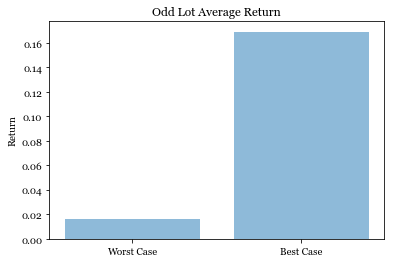

In [23]:
# Run Monte Carlo simulation to estimate expected return

# Calculate worst case return for each stock
worst_return = odd_lot_data['low'] - odd_lot_data['trading px']
worst_normalized_return = worst_return / odd_lot_data['trading px']

# Calculate best case return for each stock
best_return = odd_lot_data['high'] - odd_lot_data['trading px']
best_normalized_return = best_return / odd_lot_data['trading px']

print(worst_normalized_return)
print(worst_normalized_return.mean())
print(best_normalized_return)
print(best_normalized_return.mean())

# Plot it
labels = ('Worst Case', 'Best Case')
x_pos = np.arange(len(labels))
returns = [worst_normalized_return.mean(), best_normalized_return.mean()]
 
plt.bar(x_pos, returns, align='center', alpha=0.5)
plt.yticks(**georgia_font)
plt.xticks(x_pos, labels, **georgia_font)
plt.ylabel('Return', **georgia_font)
plt.title('Odd Lot Average Return', **georgia_font)
 
plt.show()

## Distribution of Type of Tender Offer
Below we create a pie chart and bar chart visualizing the distributions of types of tender offers. You can clearly see that "Modified Dutch Auction" is, by far, the most common type of tender. 

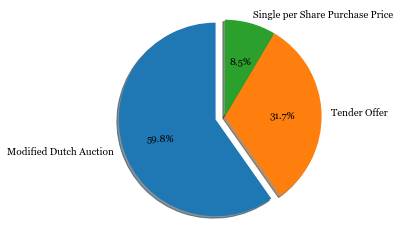

In [27]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
counts = odd_lot_data['tender type'].value_counts()
labels = counts.index
sizes = counts.values
explode = (0.1, 0, 0)  # only "explode" the largest slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops=georgia_font)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

plt.show()